In [1]:
import os
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt 
import numpy as np
import seaborn as sns

In [2]:
dataset = './Bone Fracture Dataset/'
images = []
class_name = []
list_name = ['fracture', 'normal']
BATCH_SIZE = 32 

for i, category in enumerate(os.listdir(dataset)):
    for j, file_name in enumerate(os.listdir(os.path.join(dataset, category))):
        img = load_img(os.path.join(dataset, category, file_name), target_size=(224, 224), color_mode='rgb')
        img = img_to_array(img)
        img = img/255
        class_name.append(i)
        images.append(img)
        if j > 500:
            break
        print('File name: ', file_name, 'Category: ', category)

File name:  0.png Category:  fracture
File name:  1.png Category:  fracture
File name:  10.png Category:  fracture
File name:  100.png Category:  fracture
File name:  1000.png Category:  fracture
File name:  1001.png Category:  fracture
File name:  1002.png Category:  fracture
File name:  1003.png Category:  fracture
File name:  1004.png Category:  fracture
File name:  1005.png Category:  fracture
File name:  1006.png Category:  fracture
File name:  1007.png Category:  fracture
File name:  1008.png Category:  fracture
File name:  1009.png Category:  fracture
File name:  101.png Category:  fracture
File name:  1010.png Category:  fracture
File name:  1011.png Category:  fracture
File name:  1012.png Category:  fracture
File name:  1013.png Category:  fracture
File name:  1014.png Category:  fracture
File name:  1015.png Category:  fracture
File name:  1016.png Category:  fracture
File name:  1017.png Category:  fracture
File name:  1018.png Category:  fracture
File name:  1019.png Categ

In [3]:
# Calculate Class Weights for Imbalance
# This ensures the model penalizes errors on the minority class more heavily.
class_counts = Counter(class_name)
total_samples = len(class_name)
num_classes = len(list_name)

In [4]:
print(f"class counts: {class_counts}")
print(f"total samples: {total_samples}")
print(f"num classes: {num_classes}")

class counts: Counter({0: 502, 1: 127})
total samples: 629
num classes: 2


In [5]:
class_weights = {}
# Using the provided counts (fracture: 502, normal: 127) for verification:
# Weight 0 (fracture): 629 / (2 * 502) = 0.626
# Weight 1 (normal): 629 / (2 * 127) = 2.476
for class_index, count in class_counts.items():
    # The minority class will receive a weight > 1
    weight = total_samples / (num_classes * count)
    class_weights[class_index] = round(weight, 2) # Rounding for cleaner display
    
print(f"Applying Class Weights: {class_weights}")

Applying Class Weights: {0: 0.63, 1: 2.48}


In [6]:
y = tf.keras.utils.to_categorical(class_name, num_classes=len(list_name))

In [7]:
images = np.asarray(images)
# train test split ratio = 80:10:10
x_train, x_temp, y_train, y_temp = train_test_split(images, y, test_size=0.2, random_state=67)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=67)

In [8]:
def create_model(input_shape):
    """Defines the CNN model using VGG16 for Transfer Learning."""
    
    # 1. Load VGG16 base model, excluding the final classification layers
    vgg_base = tf.keras.applications.VGG16(
        weights='imagenet',          # Use pre-trained weights
        include_top=False,           # Exclude the 3 Dense layers at the top
        input_shape=input_shape      # Must match your image size (224, 224, 1)
    )
    
    # 2. Freeze the weights of the base model
    # This prevents the pre-trained weights from changing during our training.
    vgg_base.trainable = False 
    
    # 3. Build the new classification head
    model = tf.keras.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax') # 2 classes: fracture and normal
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [9]:
model = create_model((224, 224, 3))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=15,             # Randomly rotate images by up to 15 degrees
    zoom_range=0.1,                # Randomly zoom in on images (up to 10%)
    horizontal_flip=True,          # Randomly flip images (useful for X-rays)
)

In [12]:
# Convert one-hot encoded y_train back to integer labels (0 or 1)
y_int_train = np.argmax(y_train, axis=1) 

# Map the class weight dictionary (class_weights) back to every sample in X_train.
sample_weights = np.array([class_weights[i] for i in y_int_train]) 

In [13]:
data_augmentation = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, sample_weight=sample_weights)

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    data_augmentation,
    epochs = 20,
    validation_data=(x_val, y_val),
    callbacks = early_stop,
    verbose=1
)

Epoch 1/20
16/16 [==============================] - 162s 10s/step - loss: 2.2611 - accuracy: 0.5189 - val_loss: 0.4556 - val_accuracy: 0.8095
Epoch 2/20
16/16 [==============================] - 178s 11s/step - loss: 0.6676 - accuracy: 0.6700 - val_loss: 0.7114 - val_accuracy: 0.6349
Epoch 3/20
16/16 [==============================] - 175s 11s/step - loss: 0.4610 - accuracy: 0.7475 - val_loss: 0.3656 - val_accuracy: 0.8413
Epoch 4/20
16/16 [==============================] - 155s 10s/step - loss: 0.4244 - accuracy: 0.7972 - val_loss: 0.3596 - val_accuracy: 0.8095
Epoch 5/20
16/16 [==============================] - 172s 11s/step - loss: 0.4079 - accuracy: 0.8231 - val_loss: 0.5193 - val_accuracy: 0.7143
Epoch 6/20
16/16 [==============================] - 163s 10s/step - loss: 0.3543 - accuracy: 0.8310 - val_loss: 0.3873 - val_accuracy: 0.8095
Epoch 7/20
16/16 [==============================] - 159s 10s/step - loss: 0.2889 - accuracy: 0.8608 - val_loss: 0.6385 - val_accuracy: 0.7302


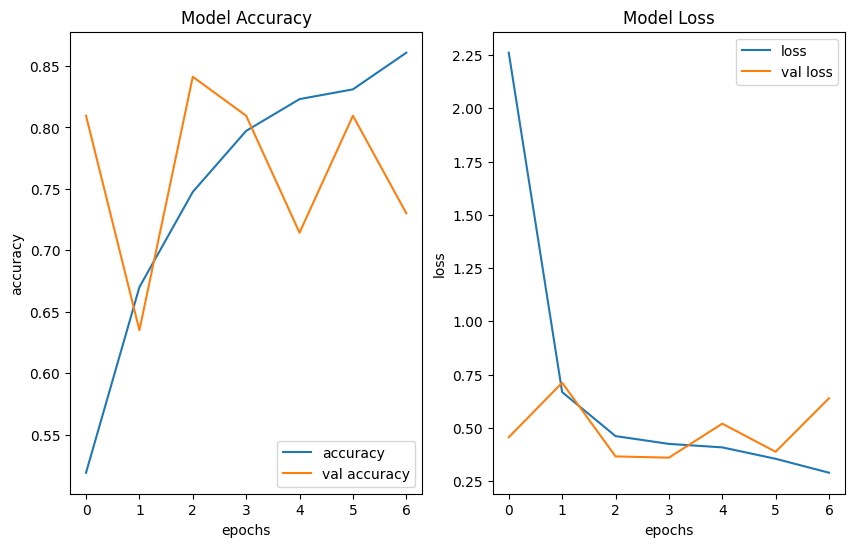

In [15]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val accuracy'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val loss'])

In [16]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

2/2 [==============================] - 17s 8s/step - loss: 0.5275 - accuracy: 0.8254
Test Accuracy: 0.83
Test Loss: 0.53


In [17]:
BATCH_SIZE = 32 
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [18]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    
    true_labels_decoded = np.argmax(labels.numpy(), axis=1)
    y_true.extend(true_labels_decoded)
    
    predicted_labels_decoded = np.argmax(preds, axis=1)
    y_pred.extend(predicted_labels_decoded)

1/1 [==============================] - 9s 9s/step


In [19]:
print(classification_report(y_true, y_pred, target_names=list_name))

              precision    recall  f1-score   support

    fracture       1.00      0.65      0.79        49
      normal       0.45      1.00      0.62        14

    accuracy                           0.73        63
   macro avg       0.73      0.83      0.71        63
weighted avg       0.88      0.73      0.75        63



In [20]:
cm = confusion_matrix(y_true, y_pred)

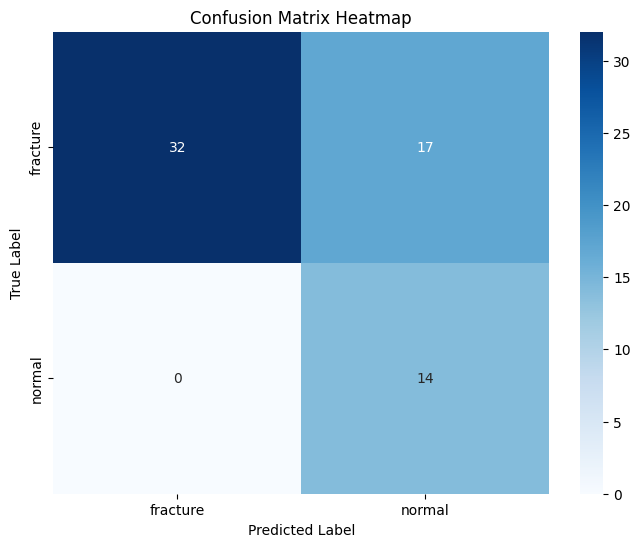

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list_name, yticklabels=list_name)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [22]:
# Export trained model
model.save('model.h5')

In [24]:
import h5py
with h5py.File('model.h5', "r") as f:
    print(list(f.keys()))

['model_weights', 'optimizer_weights']
